In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from torch.optim.lr_scheduler import StepLR

In [3]:
#expected to be a directory with submission, companyfacts, ticker.txt and company_tickers.json all available on SEC website
data_dir = "data"

facts_dir = os.path.join(data_dir, "facts")
stock_data_dir = os.path.join(data_dir, "stock_data")

company_data_dir = os.path.join(data_dir, "company_data")

submissions_dir = os.path.join(data_dir, "submission")
company_facts_dir = os.path.join(data_dir, "companyfacts")

data_csv = os.path.join(data_dir, "all_data.csv")

In [4]:
print(data_csv)
df = pd.read_csv(data_csv)
df['date'] = pd.to_datetime(df['date'])
df = df[df['target'] <= 1]
df = df.sort_values(by=['CIK', 'date'])
df.drop(["date", "open", "high", "low", "close"], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df['target'] = df['target'] *10
# df.dropna(inplace=True)
#quick fix

print(df.shape)

# pd.set_option('display.max_columns', None)
# print(df.head(10))
# pd.reset_option('display.max_columns')

# pd.set_option('display.max_rows', None)
# print(df.dtypes)
# pd.reset_option('display.max_rows')


Output_dir/all_data.csv
(1578766, 65)


In [6]:
def normalize_per_company(df, columns):
    for column in columns:
        df[column] = df.groupby('CIK')[column].transform(lambda x: (x - x.mean()) / x.std())
    return df
def normalize_globally(df, columns):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df
def min_max_normalize(df, columns):
    for column in columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    return df
def keep_original(df, columns):
    return df

In [7]:
class DataNormalizer:
    def __init__(self, df):
        self.df = df

    def normalize(self, per_company_columns=None, global_columns=None, min_max_columns=None, no_norm_columns=None):
        if per_company_columns:
            self.df = normalize_per_company(self.df, per_company_columns)
        if global_columns:
            self.df = normalize_globally(self.df, global_columns)
        if min_max_columns:
            self.df = min_max_normalize(self.df, min_max_columns)
        if no_norm_columns:
            self.df = keep_original(self.df, no_norm_columns)
        return self.df

In [8]:
per_company_columns = [
    'volume', 'daily_return', 'weekly_trend', 'SMA_5', 'SMA_15',
    'EMA_15', 'EMA_30', 'RSI_14', 'RSI_21', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'ROC_21', 'ROC_30', 'CCI_30', 'CCI_60', 'ATR_14', 'OBV', 'MFI_30', 'MFI_60', 'rolling_mean_5',
    'rolling_std_5', 'lag_1', 'lag_2', 'lag_return_1', 'bb_upper', 'bb_lower', 'bb_width'
]

global_columns = [
    'Assets','AssetsCurrent', 'Liabilities', 'NetIncomeLoss', 'Revenues', 'GrossProfit', 'OperatingIncomeLoss',
    'NetCashProvidedByUsedInOperatingActivities', 'NetCashProvidedByUsedInInvestingActivities',
    'NetCashProvidedByUsedInFinancingActivities', 'StockholdersEquity', 'RetainedEarningsAccumulatedDeficit',
    'EarningsPerShareBasic', 'EarningsPerShareDiluted', 'IncomeTaxExpenseBenefit', 'InterestExpense',
    'ComprehensiveIncomeNetOfTax','ProfitLoss', 'LiabilitiesCurrent', 'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest',
    'PropertyPlantAndEquipmentNet', 'CashAndCashEquivalentsAtCarryingValue',
    'CommonStockParOrStatedValuePerShare', 'CommonStockSharesAuthorized',
    'CommonStockSharesIssued', 'CommonStockSharesOutstanding', 'CommonStockValue',
    'WeightedAverageNumberOfDilutedSharesOutstanding', 'WeightedAverageNumberOfSharesOutstandingBasic',
    'ShareBasedCompensation', 'OperatingExpenses', 'LiabilitiesAndStockholdersEquity', 'GeneralAndAdministrativeExpense'
]

min_max_columns = [
    'CIK', 'week', 'weekday'
]

no_norm_columns = [
    "target"
]

data_normalizer = DataNormalizer(df)

df_normalized = data_normalizer.normalize(
    per_company_columns=per_company_columns,
    global_columns=global_columns,
    min_max_columns=min_max_columns,
    no_norm_columns=no_norm_columns
)

In [9]:
# print(df.shape)
# pd.set_option('display.max_columns', None)
# print(df.head(10))
# pd.reset_option('display.max_columns')

(1578766, 65)
     Assets  AssetsCurrent  CashAndCashEquivalentsAtCarryingValue  \
0 -0.059009      -0.257688                              -0.038943   
1 -0.059009      -0.257688                              -0.038943   
2 -0.059009      -0.257688                              -0.038943   
3 -0.059009      -0.257688                              -0.038943   
4 -0.059009      -0.257688                              -0.038943   
5 -0.059009      -0.257688                              -0.038943   
6 -0.059009      -0.257688                              -0.038943   
7 -0.059009      -0.257688                              -0.038943   
8 -0.059009      -0.257688                              -0.038943   
9 -0.059009      -0.257688                              -0.038943   

   CommonStockParOrStatedValuePerShare  CommonStockSharesAuthorized  \
0                                -0.01                     -0.01517   
1                                -0.01                     -0.01517   
2            

In [10]:
class StockDataset(Dataset):
    def __init__(self, df, X_columns, y_column, sequence_length=28, shuffle_cik=False):
        self.sequence_length = sequence_length
        self.X_sequences = []
        self.y_targets = []
        self.X_mask_sequences = []
        self.shuffle_cik = shuffle_cik

        grouped = df.groupby("CIK")

        # Get the list of CIK groups
        cik_groups = [group for _, group in grouped]

        # Optionally shuffle the CIKs
        if self.shuffle_cik:
            random.shuffle(cik_groups)  # Shuffle the list of CIK groups

        for group in cik_groups:
            values = group[X_columns].values
            targets = group[y_column].values

            for i in range(len(group) - sequence_length):
                X_seq = values[i:i+sequence_length]
                y_target = targets[i+sequence_length]

                X_mask = ~np.isnan(X_seq)

                # Convert to PyTorch tensors
                self.X_sequences.append(torch.tensor(np.nan_to_num(X_seq, nan=0.0), dtype=torch.float32))
                self.y_targets.append(torch.tensor(y_target, dtype=torch.float32))
                self.X_mask_sequences.append(torch.tensor(X_mask, dtype=torch.bool))

    def __len__(self):
        return len(self.X_sequences)

    def __getitem__(self, idx):
        X_seq = self.X_sequences[idx]
        y_target = self.y_targets[idx].view(1)
        X_mask = self.X_mask_sequences[idx]

        return X_seq, y_target, X_mask

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size):
        super(LSTMModel, self).__init__()

        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_layer_size, output_size)

        # self.init_weights()

    def forward(self, x, mask):
        mask = mask.to(x.device)

        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))

        # out = out * mask.unsqueeze(-1)

        out = self.fc(out[:, -1, :])

        return out

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0.01)

        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data) 
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                n = param.size(0)
                param.data[n // 4:n // 2].fill_(1.0) 


In [ ]:
y_column = 'target'
X_columns = [col for col in df.columns if col != y_column]

cik_unique = df['CIK'].unique() 
train_cik, val_cik = train_test_split(cik_unique, test_size=0.2, random_state=42)

train_df = df[df['CIK'].isin(train_cik)]
val_df = df[df['CIK'].isin(val_cik)]

batch_size = 64
sequence_length = 28

train_dataset = StockDataset(train_df, X_columns, y_column, sequence_length=sequence_length, shuffle_cik=True)
val_dataset = StockDataset(val_df, X_columns, y_column, sequence_length=sequence_length, shuffle_cik=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [13]:
input_size = len(X_columns)
hidden_layer_size = 64
num_layers = 4
output_size = 1
epochs = 180

model = LSTMModel(input_size=input_size, hidden_layer_size=hidden_layer_size, num_layers=num_layers, output_size=output_size)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
loss_function = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
train_losses = []
val_losses = []

In [ ]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y, mask in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()

        predictions = model(batch_x, mask)

        loss = loss_function(predictions, batch_y)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_epoch_loss:.4f}")
    train_losses.append(avg_epoch_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y, mask in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            mask = mask.to(device)

            predictions = model(val_x, mask)
            loss = loss_function(predictions, val_y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"{' ' * len(f'Epoch  {epoch + 1}/{epochs}')} Validation Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    val_losses.append(avg_val_loss)


Epoch 1/180, Training Loss: 0.6933
             Validation Loss: 0.5993
Epoch 2/180, Training Loss: 0.6850
             Validation Loss: 0.5947
Epoch 3/180, Training Loss: 0.6784
             Validation Loss: 0.5892
Epoch 4/180, Training Loss: 0.6722
             Validation Loss: 0.5853
Epoch 5/180, Training Loss: 0.6678
             Validation Loss: 0.5837
Epoch 6/180, Training Loss: 0.6635
             Validation Loss: 0.5795
Epoch 7/180, Training Loss: 0.6588
             Validation Loss: 0.5793
Epoch 8/180, Training Loss: 0.6544
             Validation Loss: 0.5790
Epoch 9/180, Training Loss: 0.6503
             Validation Loss: 0.5798
Epoch 10/180, Training Loss: 0.6465
              Validation Loss: 0.5818
Epoch 11/180, Training Loss: 0.6426
              Validation Loss: 0.5817
Epoch 12/180, Training Loss: 0.6398
              Validation Loss: 0.5917
Epoch 13/180, Training Loss: 0.6366
              Validation Loss: 0.5807
Epoch 14/180, Training Loss: 0.6310
              Valida

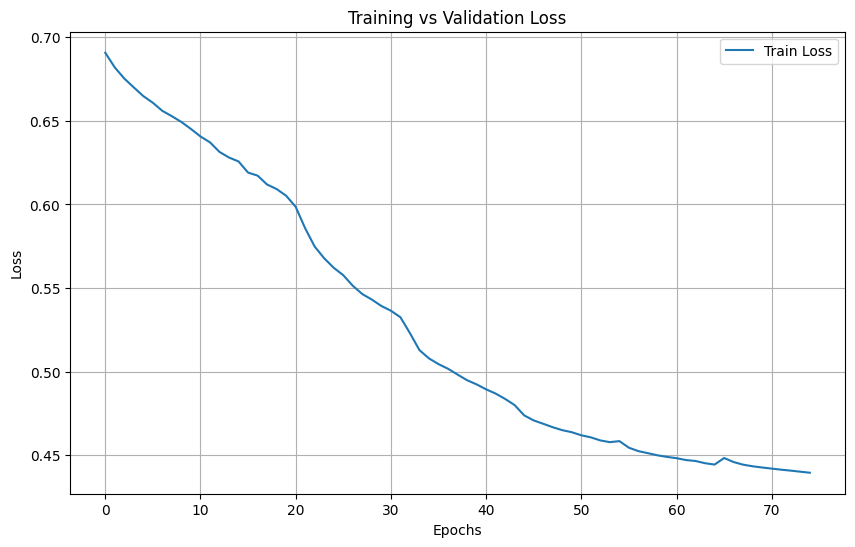

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

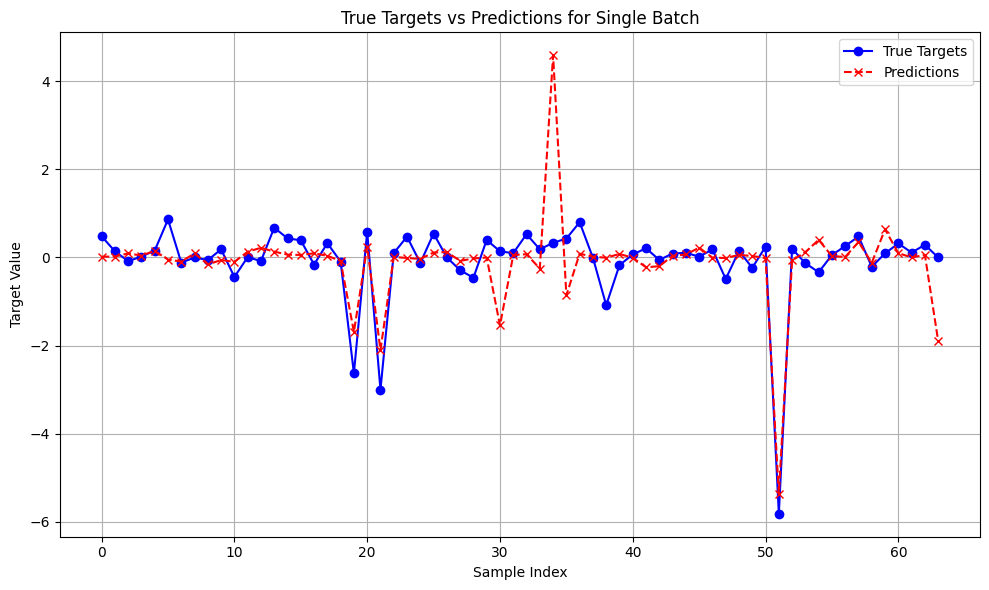

In [17]:
prediction_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

model.eval()


with torch.no_grad():
    data_iter = iter(prediction_loader)

    val_x, val_y, mask = next(data_iter)
    val_x = val_x.to(device)
    mask = mask.to(device)

    preds = model(val_x, mask).cpu().numpy()
    targets = val_y.cpu().numpy()


plt.figure(figsize=(10, 6))
plt.plot(targets.flatten(), label='True Targets', marker='o', linestyle='-', color='blue')
plt.plot(preds.flatten(), label='Predictions', marker='x', linestyle='--', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('True Targets vs Predictions for Single Batch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()